In [557]:
%pip install torch==1.9.1

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


In [1026]:
#!g1.1
import numpy as np
import pandas as pd
import torch
import torchaudio
import torchaudio.transforms as T
from torch import nn
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler, SequentialSampler

import random

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [1027]:
#!g1.1
def setup_seed(seed):
    random.seed(seed)                          
    np.random.seed(seed)                       
    torch.manual_seed(seed)                    
    torch.cuda.manual_seed(seed)               
    torch.cuda.manual_seed_all(seed)           
    torch.backends.cudnn.deterministic = True  


setup_seed(42)

In [ ]:
#!g1.1:bash
# unzip ../archive.zip

In [1028]:
#!g1.1
iemocap_features = pd.read_csv('iemocap_full_dataset.csv')

In [1029]:
#!g1.1
picked_emotions = ['ang', 'hap', 'neu', 'sad']
emotions_to_ind = {emotion: i for i, emotion in enumerate(picked_emotions)}

iemocap_features = iemocap_features[iemocap_features.emotion.isin(picked_emotions)]
iemocap_features['emotion_cat'] = iemocap_features.emotion.apply(lambda x: emotions_to_ind[x])

BASE_DATA_PATH = '../IEMOCAP_full_release/'

iemocap_features['full_path'] = iemocap_features.path.apply(lambda x: BASE_DATA_PATH + x)

In [1030]:
#!g1.1
iemocap_features

,session,method,gender,emotion,n_annotators,agreement,path,emotion_cat,full_path
0,1,script,F,neu,3,3,Session1/sentences/wav/Ses01F_script02_1/Ses01...,2,../IEMOCAP_full_release/Session1/sentences/wav...
4,1,script,F,neu,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...,2,../IEMOCAP_full_release/Session1/sentences/wav...
6,1,script,F,ang,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...,0,../IEMOCAP_full_release/Session1/sentences/wav...
7,1,script,F,ang,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...,0,../IEMOCAP_full_release/Session1/sentences/wav...
8,1,script,F,neu,3,2,Session1/sentences/wav/Ses01F_script02_1/Ses01...,2,../IEMOCAP_full_release/Session1/sentences/wav...
...,...,...,...,...,...,...,...,...,...
10034,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...,2,../IEMOCAP_full_release/Session5/sentences/wav...
10035,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...,2,../IEMOCAP_full_release/Session5/sentences/wav...
10036,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...,2,../IEMOCAP_full_release/Session5/sentences/wav...
10037,5,impro,F,neu,3,2,Session5/sentences/wav/Ses05F_impro06/Ses05F_i...,2,../IEMOCAP_full_release/Session5/sentences/wav...


<AxesSubplot:>

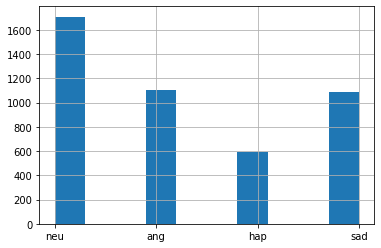

In [1032]:
#!g1.1
%matplotlib inline

iemocap_features.emotion.hist()

In [1033]:
#!g1.1
waveforms, sample_rates = zip(*iemocap_features.full_path.apply(torchaudio.load))

sample_rate = np.min(sample_rates)
max_len = max(wf.shape[1] for wf in waveforms)
min_len = min(wf.shape[1] for wf in waveforms)
min_len, max_len

(11680, 510560)

AudioMetaData(sample_rate=16000, num_frames=29119, num_channels=1, bits_per_sample=16, encoding=PCM_S)


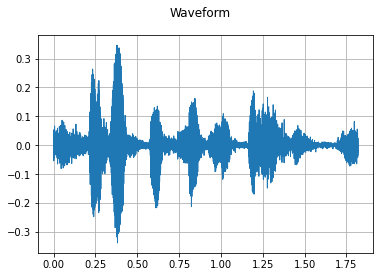

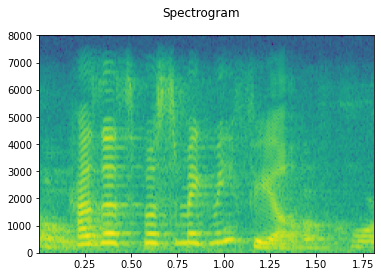

In [1034]:
#!g1.1
def plot_specgram(waveform, sample_rate, title="Spectrogram", xlim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    plt.show(block=False)
    
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f'Channel {c+1}')
        if xlim:
            axes[c].set_xlim(xlim)
        if ylim:
            axes[c].set_ylim(ylim)
    figure.suptitle(title)
    plt.show(block=False)

    
def play_audio(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    if num_channels == 1:
        display(Audio(waveform[0], rate=sample_rate))
    elif num_channels == 2:
        display(Audio((waveform[0], waveform[1]), rate=sample_rate))
    else:
        raise ValueError("Waveform with more than 2 channels are not supported.")

    
    
path = BASE_DATA_PATH + iemocap_features.iloc[3].path
print(torchaudio.info(path))

waveform, sample_rate = torchaudio.load(path)

plot_waveform(waveform, sample_rate)
plot_specgram(waveform, sample_rate)
play_audio(waveform, sample_rate)

In [1035]:
#!g1.1
device = 'cuda' if torch.cuda.is_available() else 'cpu'


class IEmoCapDataSet(Dataset):
    def __init__(self, labels, audio_paths, device, spec_size=128):
        self.labels = np.array(labels)
        self.audio_paths = np.array(audio_paths)
        self.sample_rate = sample_rate
        
        self.spec_size=spec_size
        self.device=device
        
    def __len__(self):
        return len(self.labels)
        
    def __getitem__(self, index):
        waveform, sample_rate = torchaudio.load(self.audio_paths[index])
        waveform = waveform.to(self.device)
        assert self.sample_rate == sample_rate

        spectrogram = T.MelSpectrogram(
            sample_rate=sample_rate,
            n_fft=1024,
            n_mels=self.spec_size,
            hop_length=128,
            center=True,
        ).to(device)
        waveform = spectrogram(waveform)
        return waveform, self.labels[index]


In [1036]:
#!g1.1
dataset = IEmoCapDataSet(iemocap_features['emotion_cat'], iemocap_features['full_path'], device)

In [1112]:
#!g1.1
batch_size = 128
val_split_size = .1
test_split_size = .1
shuffle_dataset = True
random_seed= 42

def collate_func(batch):
    max_len = max(wf.shape[2] for wf, _ in batch)
    melspecs, labels = zip(*batch)
    result = []
    lens = []
    for wf in melspecs:
        lens.append(wf.shape[2])
        wf_pad = torch.cat((wf, torch.zeros(wf.shape[0], wf.shape[1], max_len - wf.shape[2]).to(device)), 2)
        result.append(wf_pad)
        assert wf_pad.shape[2] == max_len
    
    return torch.stack(result, dim=0).to(device), \
           torch.tensor(lens).to(device),         \
           torch.from_numpy(np.stack(labels)).to(device)
    
    
# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
test_split = int(np.floor(test_split_size * dataset_size))
val_split = int(np.floor((test_split_size + val_split_size) * dataset_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
test_indices = indices[:test_split]
val_indices = indices[test_split:val_split]
train_indices = indices[val_split:]

# Creating PT data samplers and loaders:
train_sampler = SequentialSampler(train_indices)
valid_sampler = SequentialSampler(val_indices)
test_sampler = SequentialSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler,
                                           collate_fn=collate_func)

validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler,
                                           collate_fn=collate_func)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=test_sampler,
                                           collate_fn=collate_func)


In [1115]:
#!g1.1
# del_datasphere_variables('DCNNModel', 'model', 'optimiser')
class CNNLayer(nn.Module):
    def __init__(self, 
                  in_channels, 
                  out_channels, 
                  kernel_size, 
                  stride=(2, 2)):
        super().__init__()
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.stride = stride
        self.conv = nn.Conv2d(in_channels, 
                              out_channels, 
                              kernel_size, 
                              stride=stride, 
                              padding=self.padding)
        self.batch_norm = nn.BatchNorm2d(out_channels)
    
    @staticmethod
    def length_to_mask(length, max_len=None, dtype=None):
        """length: B.
        return B x max_len.
        If max_len is None, then max of length will be used.
        """
        assert len(length.shape) == 1, 'Length shape should be 1 dimensional.'
        max_len = max_len or length.max().item()
        mask = torch.arange(max_len, device=length.device,
                            dtype=length.dtype).expand(len(length), max_len) < length.unsqueeze(1)
        if dtype is not None:
            mask = torch.as_tensor(mask, dtype=dtype, device=length.device)
        return mask
        
    def forward(self, batch):
        features, lens = batch
        features = self.conv(features)
        lens = lens.div(self.stride[0]).ceil().type(torch.LongTensor)
        mask = length_to_mask(lens, max_len=features.shape[-1])
        mask = torch.unsqueeze(torch.unsqueeze(mask, 1), 1)
        mask = mask.repeat(1, features.shape[1], features.shape[2], 1).to(device)
        features = torch.mul(features, mask)
        
        features = F.relu(features)
        features = self.batch_norm(features)
        return (features, lens)
        
class DCNNModel(nn.Module):
    
    def __init__(self, n_classes=4):
        super().__init__()
        self.n_classes = n_classes
        
        self.conv = nn.Sequential(
            CNNLayer(1, 16, (7, 7)),
            CNNLayer(16, 32, (5, 5)),
            CNNLayer(32, 32, (3, 3)),
            CNNLayer(32, 64, (3, 3)),
            CNNLayer(64, 64, (3, 3)),   
            CNNLayer(64, 128, (3, 3)),
            CNNLayer(128, 128, (3, 3)),
        )
        
        
        self.fully_connected = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(128 * 3, 512),
            nn.Dropout(p=0.25),
            nn.Linear(512, self.n_classes),
            # no SoftMax layer in the end because 
            # CrossEntropyLoss() calculates it itself
        )

    def forward(self, batch):
        features, lens = batch
        features, lens = self.conv((features, lens))
        avg_pool = F.avg_pool2d(features, kernel_size=features.shape[2:])
        max_pool = F.max_pool2d(features, kernel_size=features.shape[2:])
        std_pool = F.lp_pool2d(features, norm_type=2, kernel_size=features.shape[2:])
        features = torch.cat((avg_pool, max_pool, std_pool), 3)
        features = self.fully_connected(features)
        return features
        

In [1117]:
#!g1.1
from IPython.display import clear_output
from tqdm import tqdm, trange
from collections import Counter

def eval_accuracy(model, data_loader):
    n_correct_guesses = 0
    model.eval()
    with torch.no_grad():
        for melspecs, melspec_lens, labels in data_loader:
            melspecs, melspec_lens, labels = melspecs.to(device), melspec_lens.to(device), labels.to(device)
            logits = model((melspecs, melspec_lens))
            predictions = logits.argmax(1)
            n_correct_guesses += (predictions == labels).float().sum() 
    return n_correct_guesses / len(data_loader.sampler)

    
def train_epoch(model, data_loader, loss_fn, optimiser, device):
    total_loss = 0
    model.train()
    for melspecs, melspec_lens, labels in data_loader:
        melspecs, melspec_lens, labels = melspecs.to(device), melspec_lens.to(device), labels.to(device)
        prediction = model((melspecs, melspec_lens))
        loss = loss_fn(prediction, labels)
        total_loss += loss
        
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
    return total_loss / len(data_loader)
    
    
def train(model, data_loader, validation_loader, loss_fn, optimiser, device, n_epochs=51):
    metrics = {'train_loss': [], 'val_accuracy': [] }

    for i in trange(n_epochs):
        loss = train_epoch(model, data_loader, loss_fn, optimiser, device)
    
        metrics['train_loss'].append((i, loss))

        if i % 10 == 0:
            metrics['val_accuracy'].append((i, eval_accuracy(model, validation_loader)))

            clear_output(True)
            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()
            print("Mean loss=%.3f" % np.mean(metrics['train_loss'][-10:], axis=0)[1], flush=True)

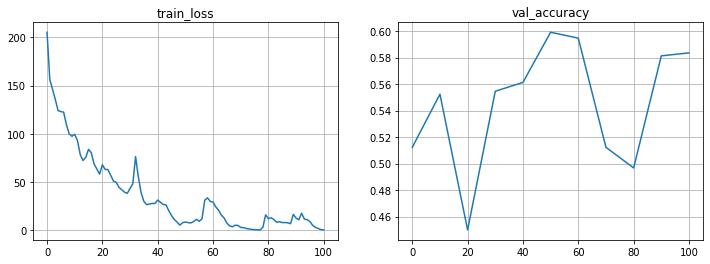

Mean loss=7.204


100%|██████████| 101/101 [29:20<00:00, 17.43s/it]



In [1118]:
#!g1.1
LEARNING_RATE = 1e-3

model = DCNNModel().to(device)
loss_fn = nn.CrossEntropyLoss(reduction='sum')
optimiser = torch.optim.Adam(model.parameters(),
                             lr=LEARNING_RATE)


train(model, train_loader, validation_loader, loss_fn, optimiser, device, n_epochs=101)

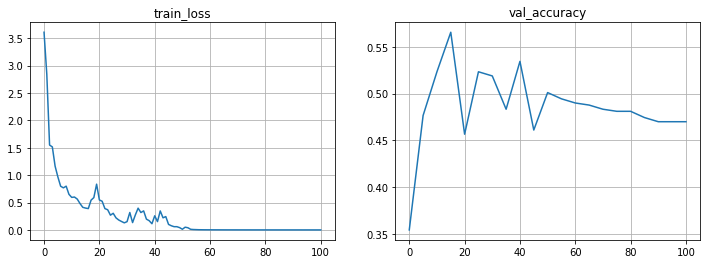

Mean loss=0.000


100%|██████████| 101/101 [37:30<00:00, 22.28s/it]


In [938]:
#!g1.1
LEARNING_RATE = 1e-3

model_val = DCNNModel().to(device)
optimiser_val = torch.optim.Adam(model_val.parameters(),
                             lr=LEARNING_RATE)


train(model_val, validation_loader, validation_loader, loss_fn, optimiser_val, device, n_epochs=101)

In [ ]:
#!g1.1
